<a href="https://colab.research.google.com/github/Mutlaq-Alqahtani/AI-AttendanceSystem/blob/main/ENSiamese_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and initializations

*   List item
*   List item



In [ ]:
import torch
import glob
%matplotlib inline
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset

# Siamese Nework with loss

## Siamese Neural Net

In [ ]:
model_name = "resnet18"
class SiameseNetwork(nn.Module):
    def __init__(self, name = "resnet18"):
        super(SiameseNetwork, self).__init__()
        self.name = name
        # Use ResNet-18 as the base network
        if self.name == "resnet18" :
            self.model = models.resnet18(pretrained=True)
            self.first = 512 * 7 * 6

        elif self.name == "resnet34":
            self.model = models.resnet34(pretrained=True)
            self.first = 512 * 7 * 6

        elif self.name == "vgg11":
            self.model = models.vgg11(pretrained=True)
            self.first = 512 * 6 * 5

        else :
            self.model = models.vgg13(pretrained=True)
            self.first = 512 * 6 * 5

        # Remove the classification layer (fc) at the end
        self.net = nn.Sequential(*list(self.model.children())[:-2])

        # Add custom layers for embedding
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.first, 512),  # Adjust input size based on your ResNet version
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
        )

    def forward_one(self, x):
        # Forward pass through one branch of the Siamese network
        x = self.net(x)

        #print(x.shape, self.name)
        x = self.embedding(x)
        return x

    def forward(self, input1, input2):
        # Forward pass through both branches
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


## Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        """
        Initialize ContrastiveLoss class. Triplet Loss

        Args:
            margin (float): Margin value for the contrastive loss.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Forward pass of the contrastive loss.

        Args:
            output1 (torch.Tensor): Tensor representing the output of the first input.
            output2 (torch.Tensor): Tensor representing the output of the second input.
            label (torch.Tensor): Binary label indicating whether the inputs are similar (0) or dissimilar (1).

        Returns:
            torch.Tensor: Contrastive loss value.
        """
        # Compute the Euclidean distance between output1 and output2
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        # Compute the contrastive loss
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

# Data Loader

## Define Dataloader

In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    # Constructor method
    def __init__(self, list1, list2, labels, transform=None):
        # Initialize dataset with provided lists and transformation function
        self.list1     = list1    # List containing paths to images 1
        self.list2     = list2    # List containing paths to images 2
        self.labels    = labels   # List containing corresponding labels
        self.transform = transform  # Transformation function to be applied to images

    # Method to get the length of the dataset
    def __len__(self):
        return len(self.labels)  # Returns the length of the labels list

    # Method to read and transform an image
    def read_image(self, image):
        image = Image.open(image)  # Open image file using PIL
        # Apply transformation function if provided
        if self.transform is not None:
            image = self.transform(image)
        return image  # Return transformed image

    # Method to get a sample from the dataset
    def __getitem__(self, idx):
        img1 = self.list1[idx]  # Get image 1 path at index idx
        img2 = self.list2[idx]  # Get image 2 path at index idx
        label = self.labels[idx]  # Get label at index idx

        # Read and transform images
        img1 = self.read_image(img1)
        img2 = self.read_image(img2)

        # Convert label to tensor
        label = torch.from_numpy(np.array([label], dtype=np.float32))

        return img1, img2, label  # Return transformed images and label


## Images Extraction

In [ ]:
def images_labels(images, balanced=True):
    # Create combinations of image pairs
    res = [(a, b) for idx, a in enumerate(images) for b in images[idx + 1:]]
    list1, list2 = [i[0] for i in res], [i[1] for i in res]

    # Initialize labels list
    labels = []

    # Initialize lists to store indices of pairs with label 1 and label 0
    ones, zeros = [], []

    # Determine labels for each pair of images
    for idx, (i, j) in enumerate(zip(list1, list2)):
        # Check if images belong to the same class
        if i.split("/")[-2] == j.split("/")[-2]:
            labels.append(0)  # Same class
            zeros.append(idx)  # Store index of pair with label 0
        else:
            labels.append(1)  # Different class
            ones.append(idx)  # Store index of pair with label 1

    # If balanced flag is set to True
    if balanced:
        final_1 = []
        final_2 = []

        # Select pairs with label 0
        for i in zeros:
            final_1.append(list1[i])
            final_2.append(list2[i])
        labels = [0] * len(zeros)  # Assign label 1 to selected pairs

        # Select pairs with label 1 (same number as label 0)
        for i in ones[:len(zeros)]:
            final_1.append(list1[i])
            final_2.append(list2[i])
        labels += [1] * len(zeros)  # Assign label 0 to selected pairs

        # Print information about the number of pairs with same and different labels
        print(f"There are {len(zeros)} pairs of images with the same labels, and {len(zeros)} pairs of different labels")

        # Return final lists of images and labels
        return final_1, final_2, labels
    else:
        # Print information about the number of pairs with same and different labels
        print(f"There are {len(zeros)} pairs of images with the same labels, and {len(zeros)} pairs of different labels")

        # Return original lists of images and labels
        return list1, list2, labels


## Get images

In [ ]:
images_train = glob.glob('/content/extracted_files/custom_celeba_500 - Copy/custom_celeba_500/train/**/*.jpg')
images_test  = glob.glob('/content/extracted_files/custom_celeba_500 - Copy/custom_celeba_500/test/**/*.jpg')
images_valid = glob.glob('**/content/extracted_files/custom_celeba_500 - Copy/custom_celeba_500/val/**/*.jpg')

In [ ]:
b1_img_tr, b2_img_tr, labels_tr    = images_labels(images_train[:])
b1_img_ts, b2_img_ts, labels_ts    = images_labels(images_test[:])
b1_img_val, b2_img_val, labels_val = images_labels(images_valid[:])

There are 8243 pairs of images with the same labels, and 8243 pairs of different labels
There are 120 pairs of images with the same labels, and 120 pairs of different labels
There are 9 pairs of images with the same labels, and 9 pairs of different labels


In [ ]:
train_dataset = CustomDataset(b1_img_tr, b2_img_tr, labels_tr,
                               #transform = transforms.Compose([transforms.Resize((218, 178)), transforms.ToTensor()]))
                              transform = transforms.Compose([
                                        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                                        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),  # Random affine transformation
                                        transforms.Resize((218, 178)),
                                        transforms.ToTensor()]))
dataloader_tr = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Visualization of the Data

0 Means The images has the same label, 1 means Not identical

In [ ]:
def plot_pairs_with_labels(images1, images2, labels):
    num_pairs = images1.size(0)

    fig, axes = plt.subplots(num_pairs, 1, figsize=(5, 5*num_pairs))

    for i in range(num_pairs):
        img1 = images1[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and permute dimensions
        img2 = images2[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and permute dimensions
        label = labels[i].item()
        if label == 0. : message = "Same person"
        else :  message = "diff. person"

        combined_img = torch.cat((images1[i], images2[i]), dim=2).permute(1, 2, 0).numpy()

        axes[i].imshow(combined_img)
        axes[i].set_title(f"Label: {label}, {message}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

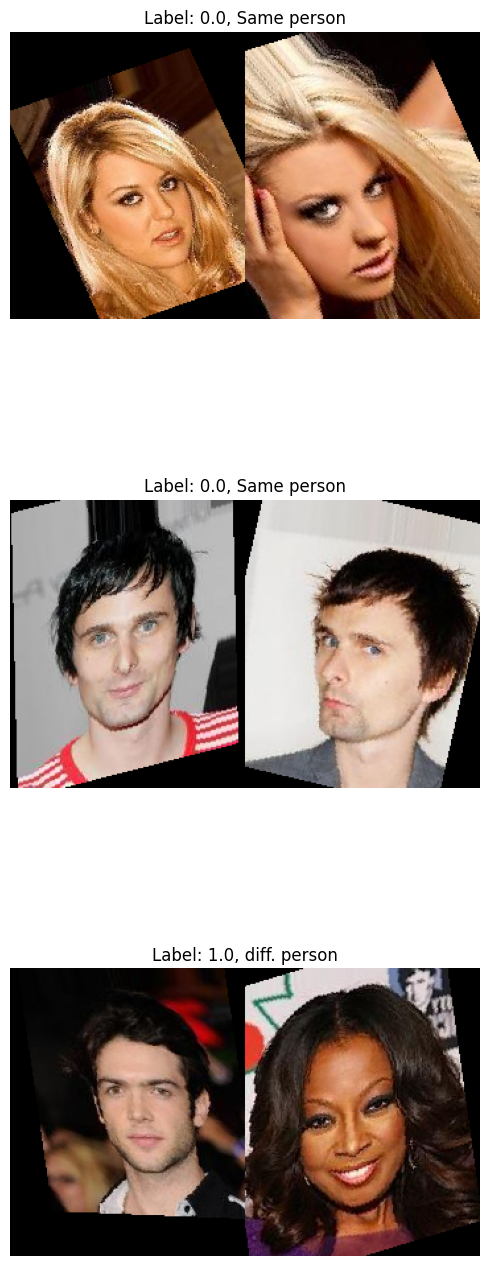

In [ ]:
dataiter = iter(dataloader_tr)

example_batch = next(dataiter)

plot_pairs_with_labels(example_batch[0][0:3], example_batch[1][0:3], example_batch[2][0:3])

# Build and training

## Model Initializations

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
names = ["resnet34", "resnet18", "vgg11", "vgg13"]


## Training and plot loss

In [ ]:
from tqdm import tqdm
epochs = 3
for name in names :
    net = SiameseNetwork(name = name).to(device)
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(),lr = 0.0001 )
    counter = []
    loss_history = []
    iteration_number= 0
    epoch_losses = []

    # Initialize a variable to store the lowest loss encountered
    lowest_loss = float('inf')


    for epoch in range(0, epochs):
        epoch_loss = 0.0  # Initialize epoch loss
        # Wrap the dataloader with tqdm to visualize the progress bar
        with tqdm(dataloader_tr, desc=f'{name} Epoch  {epoch}', unit='batch') as tqdm_loader:
            for i, data in enumerate(tqdm_loader, 0):
                img0, img1, label = data
                img0, img1, label = img0.to(device), img1.to(device), label.to(device)
                optimizer.zero_grad()
                output1, output2 = net(img0, img1)
                loss_contrastive = criterion(output1, output2, label)
                loss_contrastive.backward()
                optimizer.step()

                epoch_loss += loss_contrastive.item()  # Accumulate loss for the epoch

                iteration_number += 1
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

                tqdm_loader.set_postfix({'loss': loss_contrastive.item()}, refresh=False)

        # Calculate average epoch loss
        epoch_loss /= len(dataloader_tr)
        epoch_losses.append(epoch_loss)

        print("Epoch {} average loss: {}".format(epoch, epoch_loss))

        # Save the model if the current epoch's loss is lower than the lowest loss encountered
        if epoch_loss < lowest_loss:
            lowest_loss = epoch_loss

            # Define the path where you want to save the best model
            best_model_path = f"./models/model-{name}-epoch-{epoch}_loss-{str(lowest_loss)[0:6]}.pth"
            # Save the model
            torch.save(net.state_dict(), best_model_path)
            print("Model saved at epoch {} with lowest loss: {}".format(epoch, lowest_loss))

    np.save(f'./saves/losses_{name}.npy', np.array(loss_history))

/home/rcam/anaconda3/envs/PhD_Ten/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rcam/anaconda3/envs/PhD_Ten/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
resnet34 Epoch  0: 100%|██████| 258/258 [01:48<00:00,  2.37batch/s, loss=0.0161]
/home/rcam/anaconda3/envs/PhD_Ten/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is 

Epoch 0 average loss: 0.15866046144930257
Model saved at epoch 0 with lowest loss: 0.15866046144930257


resnet18 Epoch  0: 100%|██████| 258/258 [01:10<00:00,  3.67batch/s, loss=0.0256]
/home/rcam/anaconda3/envs/PhD_Ten/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 average loss: 0.1369463728502566
Model saved at epoch 0 with lowest loss: 0.1369463728502566


vgg11 Epoch  0: 100%|███████| 258/258 [02:32<00:00,  1.69batch/s, loss=0.000621]


Epoch 0 average loss: 0.053457261156617905
Model saved at epoch 0 with lowest loss: 0.053457261156617905


/home/rcam/anaconda3/envs/PhD_Ten/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
vgg13 Epoch  0:   4%|▍          | 11/258 [00:10<04:06,  1.00batch/s, loss=0.229]


KeyboardInterrupt: 

### Plot loss

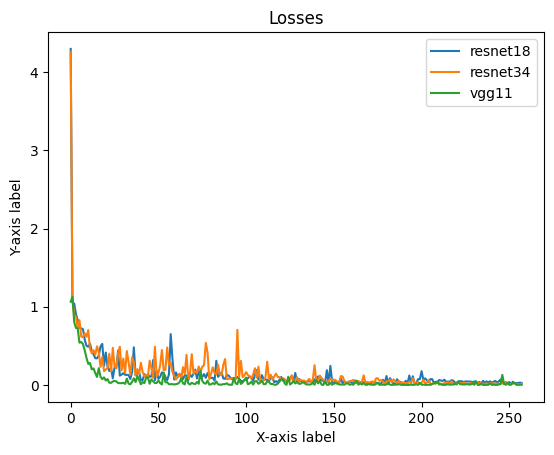

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to plot data from all npy files in a folder
def plot_data_from_folder(folder_path):
    # Get all file names in the folder
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

    # Iterate through each file
    for idx, file_name in enumerate(file_names):
        idx = (file_name.split('.')[0]).split('_')[-1]
        # Load data from the npy file
        data = np.load(os.path.join(folder_path, file_name))

        # Plot data with different color for each file
        plt.plot(data, label=idx)

    # Add labels and legend
    plt.xlabel('X-axis label')
    plt.ylabel('Y-axis label')
    plt.title('Losses')
    plt.legend()

    # Show plot
    plt.show()

# Example usage: Specify the path to the folder containing npy files
folder_path = './saves'
plot_data_from_folder(folder_path)
